**<h1>Práctica computacional: modelo de Ising en 2D</h1>**

El objetivo de la práctica es calcular varios observables (magnetización, energía, susceptibilidad, calor específico) de una red de Ising bidimensional en función de la temperatura, y ver cómo a $T\simeq 2.27$ (usamos unidades en las que $J=k=1$) tiene lugar una transición de fase. También calcularemos la función de correlación y estudiaremos la dependencia de la longitud de correlación con la temperatura. Dado que el número de términos en la función de partición es gigantesco ($2^{100}$ para una red $10\times 10$, algo así como la edad del universo en décimas de picosegundo), no podemos aspirar a calcular la función de partición exactamente. En su lugar, lo que hacemos es generar estados aleatorios de la red distribuidos según el ensamble canónico, y tomar promedios sobre varios de esos estados. Para lograr eso, partimos de un estado inicial cualquiera y le aplicamos el **algoritmo de Metropolis**, que consta de los siguientes pasos:

1.   Elegimos un sitio de la red al azar.
2.   Calculamos la diferencia de energía $\Delta E$ que resultaría de darle vuelta a ese spin.
3. Si $\Delta E\le 0$, le damos vuelta al spin; si $\Delta E>0$, le damos vuelta al spin con probabilidad $e^{-\beta\Delta E}$.

Al estado resultante le volvemos a aplicar el algoritmo, y así sucesivamente. Después de ser iterado muchas veces, el algoritmo empieza a generar estados distribuidos según el ensamble canónico. Tomando promedios sobre varios de esos estados, podremos calcular los observables de interés.

# Bibliotecas

Importamos las bibliotecas de Python que vamos a usar: numpy, que permite definir y operar con matrices, genera números aleatorios, incluye todo tipo de funciones matemáticas, etc; matplotlib.pyplot, que permite hacer gráficos; y numba, que es un compilador que hace que las funciones corran mucho más rápido. También importamos la función curve_fit del paquete scipy.optimize, que nos servirá para hacer ajustes.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
from scipy.optimize import curve_fit

# Funciones

Aquí van a tener que definir dos funciones. La primera, **`h(S)`**, calcula la energía por partícula de la red en el estado **`S`** (nótese que **`S`** es una matriz de $1$'s y $-1$'s). Asumimos que no hay campo magnético y usamos condiciones de contorno periódicas, de manera que el primer spin de una fila/columna es vecino del último. Si la red es $L\times L$, la energía total es entonces

$$H(S)=-\sum_{i,j=1}^L S_{ij}(S_{i-1 j}+S_{ij-1}),$$

y la energía por partícula es esto dividido por $L^2$. La segunda función, **`metropolis(S,prob)`**, aplica el algoritmo de Metropolis al estado **`S`** y devuelve tres cosas: un nuevo estado **`S`**, el incremento de magnetización **`dm`** y el incremento de energía por partícula **`de`**. Deben notar que los únicos valores positivos que puede tomar el incremento de energía $\Delta E$ resultante de dar vuelta a un spin son $\Delta E=4$ y $\Delta E=8$; el argumento **`prob`** es un vector de dos componentes, **`prob[0]`** y **`prob[1]`**, que son las probabilidades con las que daremos vuelta al spin si el incremento de energía es $4$ y $8$ respectivamente. Algunos consejos:


*   Para implementar las condiciones de contorno periódicas, conviene recordar que las listas de Python empiezan con el elemento $0$, el elemento $-1$ es el último, el $-2$ el penúltimo, etc. También les va a ser útil la función **`%`**, que calcula el residuo de la división entre dos enteros (es decir, **`m%n`** es el residuo de la división entre **`m`** y **`n`**).
*   ¡Sean económicos! Para calcular $\Delta E$ no deben calcular la energía total de los dos estados (el estado original y el estado con el spin seleccionado dado vuelta) y restar, sino darse cuenta de que esta cantidad sólo involucra al estado del spin seleccionado y el de sus cuatro primeros vecinos.
*   Para dar vuelta a un spin con probabilidad $p$, lo que hacemos es generar un número aleatorio entre $0$ y $1$ y darle vuelta al spin si ese número es menor que $p$.

Una vez hayan definido estas funciones, primero de todo asegúrense de que andan bien probándolas con una matriz $3\times 3$, por ejemplo tomando **`S=np.ones((3,3))`**. Ahí pueden calcular a mano la energía por partícula y chequear que **`h(S)`** da el resultado correcto. También pueden asegurarse de que, partiendo de esta misma matriz, la funcion **`metropolis(S,prob)`** da vuelta a algún spin más fácilmente a temperaturas altas que a temperaturas bajas, y que los incrementos de magnetización y energía por partícula que calcula son los correctos. Una vez hayan hecho eso, redefinan la función **`metropolis(S,prob)`** de manera que aplique el algoritmo de Metropolis no una sola vez sino tantas como sitios tiene la red. Es decir, su función definitiva debería aplicar el algoritmo al estado original, y después volvérselo a aplicar al estado resultante, y así tantas veces como sitios tiene la red. De vuelta, comprueben que esta función anda bien con una matriz sencilla.

In [ ]:
@njit #Para que numba compile la función
def h(S): #Calcula la energía de la red en el estado S
  '''
  input
  S: Matriz de LxL

  Output
  h: Valor del hamiltoniano para la matriz S
  '''

  m,n = np.shape(S)
  h=0
  for i in range(m):
    for j in range(n):
      y = -S[i,j]*(S[i-1,j]+S[i,j-1]) # y es incremento de H
      h += y #aca lo sumo a h

  return h/(m**2) # dividido por L²

@njit
def metropolis(S,prob): #Aplica el algoritmo de Metropolis al estado S
                        #necesito conocer el S y la temperatura pues necesito el beta
  """
  input
  S: Matriz de LxL
  prob: probabilidad de cambio de spin

  output
  S: Nuevo estado de S
  dm: incremento en la magnetizacion
  de: incremento en la energia
  """

  m,n = np.shape(S)

  w = 0 #item para iterar
  S_final = np.copy(S) #Esta una copia de la matriz original (a w=0), que iremos cambiando con cada
                       #iteracion para que sea el output
  dm_ = 0
  de_ = 0

  while w < (m**2): #repito por los N sitios de la red
    w += 1 # para iterar en el while loop

    #elementos al azar de la red para la iteracion w
    i= np.random.randint(0,m)
    j= np.random.randint(0,n)

    #copio la matriz base para la w-esima iteracion y cambio el
    #spin del lugar (i,j)
    S_0 = np.copy(S_final)
    cambio = (-1)*S_0[i,j]
    S_0[i,j] = cambio

    #incremento de energia por particula, si cambio en S_0
    de= 0 #total de la serie
    for k in [-1,0,1]:
      for l in [-1,0,1]:
        a = i+k
        b = j+l

        if a%m ==0:
          a=0

        if b%n==0:
          b=0

        de += -S_0[a,b]*(S_0[a-1,b]+S_0[a,b-1])+ S_final[a,b]*(S_final[a-1,b]+S_final[a,b-1]) #diff de energia
                                                                                              #entre S con el cambio y
                                                                                              #la matriz de la w-esima iteracion

    # esta flag es para que ocurran cosas si se acepta el cambio
    flag = False

    if de <= 0:
      S_final = np.copy(S_0) #ACEPTAMOS EL CAMBIO
      flag = True
    elif de == (4):
      toss = np.random.rand()  #evento entre [0,1)
      if toss < prob[0]:
        S_final = np.copy(S_0) #ACEPTAMOS EL CAMBIO
        flag = True
      else:
        pass #No pasa nada, siga participando
    elif de == (8):
      toss = np.random.rand() #evento entre [0,1)
      if toss < prob[1]:
        S_final = np.copy(S_0) #ACEPTAMOS EL CAMBIO
        flag = True
      else:
        pass #No pasa nada, siga participando

    dm = 0
    if flag == True: #si acepta el cambio, hay un cambio de de y dm
      dm = np.sign(cambio)*(2/(m**2)) #cambio en m, saltos de 2/N, de acuerdo al
                                      #signo del cambio
      de_+=de/(m**2) #por particula
      dm_ += dm

  return S_final, dm_, de_

Para definir la función **`h(S)`** nos basamos en la definición del Hamiltoniano, haciendo la suma con un **`for`** pero devidiendo por $L^2$ el valor del hamiltroniano para así obtener la energía por partícula en la red.

Para poder construir el algortítmo de Metropolis de manera adecuada era necesario que se repitiese la iteración muchas veces para así conseguir que la probabilidad a la que se llegase tendiera a la dada por el ensable cacónico. Por eso, en el código se itera **`w<(m**2)`** pues **`m**2`** son todos los sitios de la red. De esta manera, vamos iterando y plantenado un cambio del spin en algún sitio aleatorio de la red. Una vez realiazo el cambio, se evalúa la variación de energía que genera ese cambio, en donde la misma se corresponde con los términos de la sumatoria que involucran el spin cambiado. Así, calculamos el **`de`** de forma más óptima.

Una vez que tenemos el diferencial **`de`** evaluamos si se acepta o no el cambio. Para esto definimos **`flag`**, en donde si **`flag=True`** se acepta el cambio del spin entonces habrá un **`dm`** y un **`de`**. Si **`flag=False`** no se acepta el cambio de spin propuesto. El uso del **`flag`** fue necesario puesto que sino se sumaban los diferenciales **`dm`** y **`de`**, fuese aceptado o no el cambio realmente.

Los parámetros utilizados para aceptar o no los cambios eran aquellos dados por el algoritmo de Metropolis pero en donde la probabilidad $e^{-\beta \Delta E}$ se construyó tomando un número aleatorio entre $[0,1)$. Así mismo, dado que los cambios de energía posible que cumpliesen $0 ≤ \Delta E$ son aquellos en donde $\Delta E =4$ o $\Delta E = 8$, las condiciones en las cuales se dividió el estudio para aceptar o no el cambio en función del $\Delta E$ que genera entre la matriz original y la modificada fueron $\Delta E ≤0$, $\Delta E =4$ y $\Delta E = 8$.


Una vez es aceptado el cambio, se calcula el valor de **`dm`** y el **`de`**. La variación de energía **`de`** es el calculado para ver si el cambio era aceptado o no pero dividido por $m^2$ para que sea el cambio de energía por particula. Por otro lado, la variación en la magnetización **`dm`** fue calculada sabiendo que cada spin modificado hará cambios de a $2/N$ donde $N$ son la cantidad de elementos de la red. Así mismo, la contribución será negativa o positiva, dependiendo del spin modificado.

# Termalización

Partiendo de un cierto estado inicial, estudiamos cuántos pasos son necesarios para que el sistema llegue al equilibrio, es decir, para que los distintos estados empiecen a estar distribuidos según el ensamble canónico. Para eso, graficamos la magnetización y la energía por partícula en función del paso; el equilibrio se alcanza cuando estas cantidades empiezan a fluctuar alrededor de un valor fijo, en lugar de ser netamente crecientes o decrecientes.
El número de pasos necesarios para alcanzar el equilibrio dependerá de la temperatura, así que hay que hay que hacer el análisis para varias temperaturas. También puede depender del lado de la red, así que cuando cambien el valor de este parámetro van a tener que rehacer este análisis. Fíjense que, cerca de la temperatura crítica, la magnetización oscila entre $1$ y $-1$.

Estudiamos primero el caso para una matriz $S$ de todos $1$.

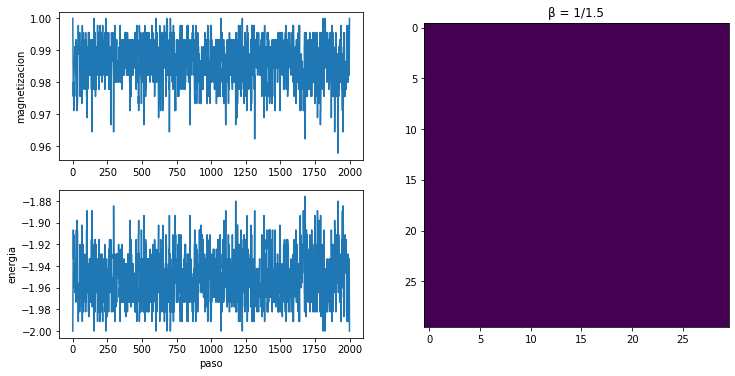

In [ ]:
L=30 #Lado de la red
beta=1/1.5

nequilibrio=2000 #Numero de pasos tentativo para llegar al equilibrio

prob=np.array([np.exp(-4*beta),np.exp(-8*beta)])

#Estado inicial
#Opcion 1: todos los spines apuntan para arriba
S=np.ones((L,L),dtype=int)
#Opcion 2: matriz aleatoria de 1's y -1's
#S=2*np.random.randint(2,size=(L,L))-1

m=np.zeros(nequilibrio) #magnetización en función del paso
e=np.zeros(nequilibrio) #energia por particula en funcion del paso
m[0]=np.mean(S)
e[0]=h(S)

for n in range(1,nequilibrio): #para hacer un monton de pasos
  S,dm,de=metropolis(S,prob)
  m[n]=m[n-1]+dm #no hace falta volver a calcular el min, basta con sumarle dm al paso anterior
  e[n]=e[n-1]+de #idem la idea de arriba

plt.figure(figsize=(12,6))
plt.subplot(2,2,1)
plt.plot(m)
plt.ylabel('magnetizacion')
plt.subplot(2,2,3)
plt.plot(e)
plt.ylabel('energia')
plt.xlabel('paso')
plt.subplot(1,2,2)
plt.imshow(S) #plotea el estado final, dandole un color al 1 y otro al -1
plt.title('β = 1/1.5')
plt.show()

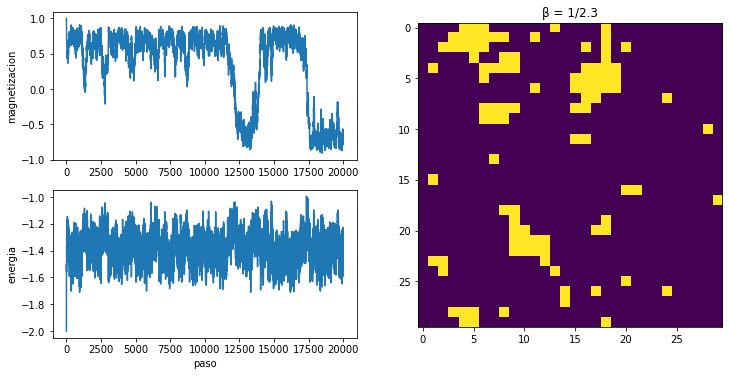

In [ ]:
L=30 #Lado de la red
beta=1/2.3

nequilibrio=20000 #Numero de pasos tentativo para llegar al equilibrio

prob=np.array([np.exp(-4*beta),np.exp(-8*beta)])

#Estado inicial
#Opcion 1: todos los spines apuntan para arriba
S=np.ones((L,L),dtype=int)
#Opcion 2: matriz aleatoria de 1's y -1's
#S=2*np.random.randint(2,size=(L,L))-1

m=np.zeros(nequilibrio) #magnetización en función del paso
e=np.zeros(nequilibrio) #energia por particula en funcion del paso
m[0]=np.mean(S)
e[0]=h(S)

for n in range(1,nequilibrio): #para hacer un monton de pasos
  S,dm,de=metropolis(S,prob)
  m[n]=m[n-1]+dm #no hace falta volver a calcular el min, basta con sumarle dm al paso anterior
  e[n]=e[n-1]+de #idem la idea de arriba

plt.figure(figsize=(12,6))
plt.subplot(2,2,1)
plt.plot(m)
plt.ylabel('magnetizacion')
plt.subplot(2,2,3)
plt.plot(e)
plt.ylabel('energia')
plt.xlabel('paso')
plt.subplot(1,2,2)
plt.imshow(S) #plotea el estado final, dandole un color al 1 y otro al -1
plt.title('β = 1/2.3')
plt.show()

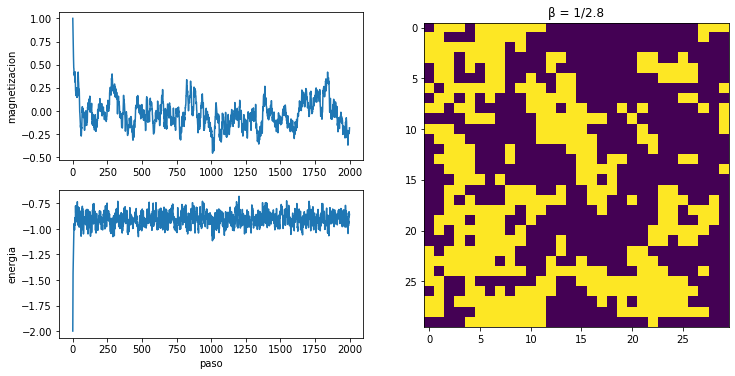

In [ ]:
L=30 #Lado de la red
beta=1/2.8

nequilibrio=2000 #Numero de pasos tentativo para llegar al equilibrio

prob=np.array([np.exp(-4*beta),np.exp(-8*beta)])

#Estado inicial
#Opcion 1: todos los spines apuntan para arriba
S=np.ones((L,L),dtype=int)
#Opcion 2: matriz aleatoria de 1's y -1's
#S=2*np.random.randint(2,size=(L,L))-1

m=np.zeros(nequilibrio) #magnetización en función del paso
e=np.zeros(nequilibrio) #energia por particula en funcion del paso
m[0]=np.mean(S)
e[0]=h(S)

for n in range(1,nequilibrio): #para hacer un monton de pasos
  S,dm,de=metropolis(S,prob)
  m[n]=m[n-1]+dm #no hace falta volver a calcular el min, basta con sumarle dm al paso anterior
  e[n]=e[n-1]+de #idem la idea de arriba

plt.figure(figsize=(12,6))
plt.subplot(2,2,1)
plt.plot(m)
plt.ylabel('magnetizacion')
plt.subplot(2,2,3)
plt.plot(e)
plt.ylabel('energia')
plt.xlabel('paso')
plt.subplot(1,2,2)
plt.imshow(S) #plotea el estado final, dandole un color al 1 y otro al -1
plt.title('β = 1/2.8')
plt.show()

Estudiamos el caso para una matriz aleatoria de $1$ y $-1$

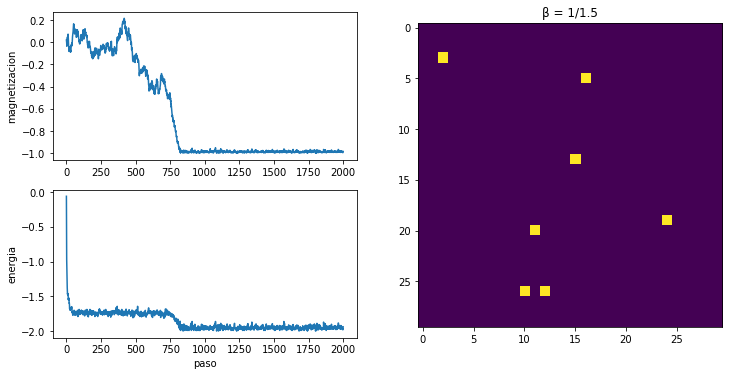

In [ ]:
L=30 #Lado de la red
beta=1/1.5

nequilibrio=2000 #Numero de pasos tentativo para llegar al equilibrio

prob=np.array([np.exp(-4*beta),np.exp(-8*beta)])

#Estado inicial
#Opcion 1: todos los spines apuntan para arriba
#S=np.ones((L,L),dtype=int)
#Opcion 2: matriz aleatoria de 1's y -1's
S=2*np.random.randint(2,size=(L,L))-1

m=np.zeros(nequilibrio) #magnetización en función del paso
e=np.zeros(nequilibrio) #energia por particula en funcion del paso
m[0]=np.mean(S)
e[0]=h(S)

for n in range(1,nequilibrio): #para hacer un monton de pasos
  S,dm,de=metropolis(S,prob)
  m[n]=m[n-1]+dm #no hace falta volver a calcular el min, basta con sumarle dm al paso anterior
  e[n]=e[n-1]+de #idem la idea de arriba

plt.figure(figsize=(12,6))
plt.subplot(2,2,1)
plt.plot(m)
plt.ylabel('magnetizacion')
plt.subplot(2,2,3)
plt.plot(e)
plt.ylabel('energia')
plt.xlabel('paso')
plt.subplot(1,2,2)
plt.imshow(S) #plotea el estado final, dandole un color al 1 y otro al -1
plt.title('β = 1/1.5')
plt.show()

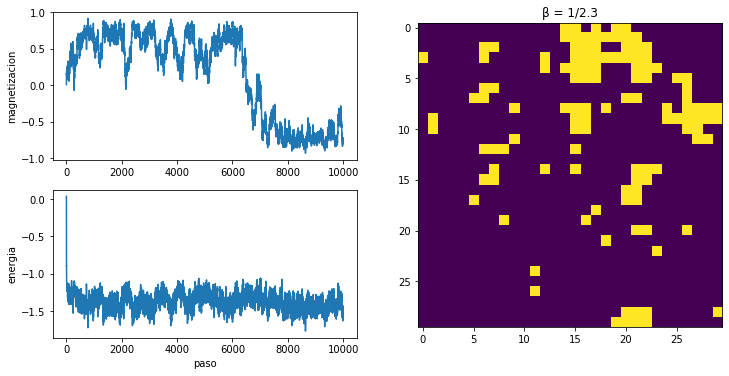

In [ ]:
L=30 #Lado de la red
beta=1/2.3

nequilibrio=10000 #Numero de pasos tentativo para llegar al equilibrio

prob=np.array([np.exp(-4*beta),np.exp(-8*beta)])

#Estado inicial
#Opcion 1: todos los spines apuntan para arriba
#S=np.ones((L,L),dtype=int)
#Opcion 2: matriz aleatoria de 1's y -1's
S=2*np.random.randint(2,size=(L,L))-1

m=np.zeros(nequilibrio) #magnetización en función del paso
e=np.zeros(nequilibrio) #energia por particula en funcion del paso
m[0]=np.mean(S)
e[0]=h(S)

for n in range(1,nequilibrio): #para hacer un monton de pasos
  S,dm,de=metropolis(S,prob)
  m[n]=m[n-1]+dm #no hace falta volver a calcular el min, basta con sumarle dm al paso anterior
  e[n]=e[n-1]+de #idem la idea de arriba

plt.figure(figsize=(12,6))
plt.subplot(2,2,1)
plt.plot(m)
plt.ylabel('magnetizacion')
plt.subplot(2,2,3)
plt.plot(e)
plt.ylabel('energia')
plt.xlabel('paso')
plt.subplot(1,2,2)
plt.imshow(S) #plotea el estado final, dandole un color al 1 y otro al -1
plt.title('β = 1/2.3')
plt.show()

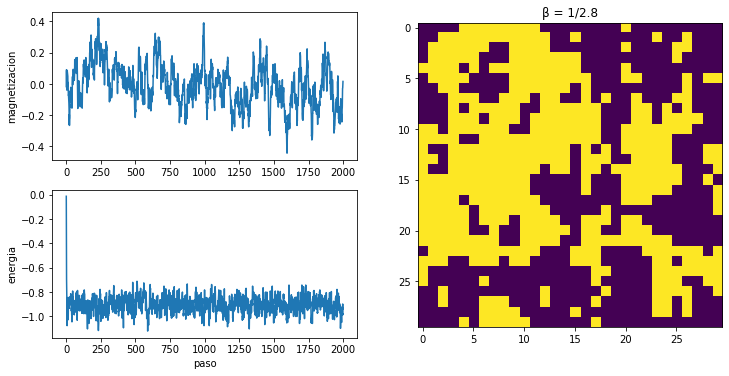

In [ ]:
L=30 #Lado de la red
beta=1/2.8

nequilibrio=2000 #Numero de pasos tentativo para llegar al equilibrio

prob=np.array([np.exp(-4*beta),np.exp(-8*beta)])

#Estado inicial
#Opcion 1: todos los spines apuntan para arriba
#S=np.ones((L,L),dtype=int)
#Opcion 2: matriz aleatoria de 1's y -1's
S=2*np.random.randint(2,size=(L,L))-1

m=np.zeros(nequilibrio) #magnetización en función del paso
e=np.zeros(nequilibrio) #energia por particula en funcion del paso
m[0]=np.mean(S)
e[0]=h(S)

for n in range(1,nequilibrio): #para hacer un monton de pasos
  S,dm,de=metropolis(S,prob)
  m[n]=m[n-1]+dm #no hace falta volver a calcular el min, basta con sumarle dm al paso anterior
  e[n]=e[n-1]+de #idem la idea de arriba

plt.figure(figsize=(12,6))
plt.subplot(2,2,1)
plt.plot(m)
plt.ylabel('magnetizacion')
plt.subplot(2,2,3)
plt.plot(e)
plt.ylabel('energia')
plt.xlabel('paso')
plt.subplot(1,2,2)
plt.imshow(S) #plotea el estado final, dandole un color al 1 y otro al -1
plt.title('β = 1/2.8')
plt.show()

Partiendo de un matriz de todos $1$ obtenemos que:

* Para $T < T_c$, en donde **`beta = 1/1.5`** y **`nequilibrio=2000`**, se alcanza el equilibrio térmico rapidamente, practicamente arranca termalizado el sistema. La red de spines termina con practicamente todos apuntando en la misma dirección, lo cual es esperable para temperaturas menores a la crítica.
* Para $T \sim T_c$, donde **`beta = 1/2.3`** y **`nequilibrio=20000`**, llegando a la termalización del sistema con alrededor de 1500 pasos. En este caso, se observa que los spines oscilan entre $1$ y $-1$, lo cual es de esperarse para valores de temperatura cercanos al de la crítica.
* Para $T > T_c$, donde **`beta = 1/2.8`** y **`nequilibrio=2000`**, se alcanza el equilibrio térmico para 250 pasos, lo cual es más rápido que el caso de $T \sim T_c$ pero más lento que el de $T<T_c$. Esto es consecuencia de que, partiendo de una red en donde todos los spines apuntan en la misma dirección, el equilibrio a temperaturas altas implica "desordenar" esto y tarda más que para temperaturas bajas.


También utilizamos un matriz de $1$ y $-1$ aleatorios.  
* Para $T < T_c$, en donde **`beta = 1/1.5`** y **`nequilibrio=2000`**, se tarda entre 250 y 1500 pasos aproximadamente dependiendo de cuál es la matriz aleatoria de la que partis. Esta diferencia entre la cantidad de pasos es esperable tomando en cuenta que la matriz de la que se parte cada vez que se corre el código es aleatoria. Dicha aleatoriedad puede implicar más o menos spines alineados, lo cual implica que puede tardar más o menos en llegar al equilibrio. Nuevamente, los spines apuntan casi todos en la misma dirección una vez termalizado el sistema pero se tarda más en llegar a este equilibrio que con la red de spines todos alineados. Además, en ese caso, dependiendo de con qué matriz aleatoria se comienza, se termina con la mayoria de spines apuntando en $1$ o en $-1$, a diferencia del caso anterior donde siempre se alcanzaba en $1$.
* Para $T \sim T_c$, donde **`beta = 1/2.3`** y **`nequilibrio=20000`**, alcanzando la termalización alrededor de los 1500 pasos. Nuevamente en este caso se ve la oscilación de la magnetización entre $1$ y $-1$.
* Para $T > T_c$, donde **`beta = 1/2.8`** y **`nequilibrio=2000`**, el equilibrio térmico se alcanza muy rápido porque el sistema arranca practicamente desde el equilibrio por partir de una matriz de $1$ y $-1$ aleatorios. Nuevamente, en el equilibrio no hay magnetización entonces los spines se encuentran aleatorios. Partiendo de una red aleatoria, esto se alcanza más rápido que en el caso de la red de todos $1$.

Comparamos lo que ocurre para una matriz de todos $1$ y para una matriz de $1$ y $-1$ pues, en el caso de $T<T_c$, el sistema termalizará más rapido para la matriz de todos $1$ que para la de $1$ y $-1$ aleatorios dado que el equilibrio se alcanzará cuando todos los spines apunten en la misma dirección. En el caso contrario, para $T>T_c$, el equlibrio se alcanza más rapido con una matriz aleatoria de $1$ y $-1$ dado que en estas condiciones la termalización se alcanza cuando los spines están aleatorios puesto que no hay magnetización. Para el caso de $T \sim T_c$ partir de la red de todos spines de $1$ o de la aleatoria de $1$ y $-1$ no influye significativamente en los pasos necesarios para la termalización del sistema.

*Aclaración:* las fluctuaciones que se observan para cuando decimos que el sistema está termalizado son consecuencia de estar trabajando con una cadena finita. En el límite termodinámico, tenderán a cero.


# Promedios

Estudiamos cuántos pasos hacen falta para calcular buenos promedios. Para eso, graficamos el valor medio de la magnetización y la energía por partícula en función del número de pasos utilizados para calcularlo (empezando a contar después de haber llegado al equilibrio). Cuando el valor medio se haga constante, el número de pasos será suficiente. De vuelta, el número de pasos apropiado depende de la temperatura y del lado de la red. Van a ver que, cerca de la temperatura crítica, las fluctuaciones se hacen más grandes y por lo tanto es necesario promediar sobre un número más grande de pasos. Para librarnos de las fluctuaciones de la magnetización entre $1$ y $-1$ cerca de la temperatura crítica, que son inmanejables, lo que tomamos es el valor medio de su módulo.

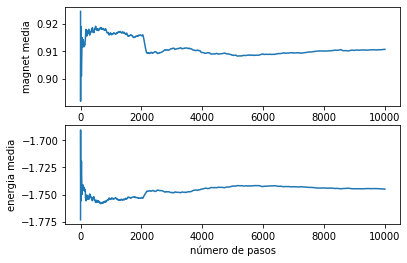

In [ ]:
L=30
beta=1/2

nequilibrio=1000 #Este valor lo decidimos en base a lo anterior
#nequilibrio me dice que metropolis lo aplico 1000 veces
#y (creo) a partir de ese equilibrio es que promediamos
npromedio=10000 #Numero de pasos tentativo para calcular promedios

prob=np.array([np.exp(-4*beta),np.exp(-8*beta)])

S=np.ones((L,L),dtype=int) #Estado inicial

for n in range(nequilibrio):
  S,dm,de=metropolis(S,prob) #Termalizamos

m=np.zeros(npromedio)
e=np.zeros(npromedio) #Magnetizacion y energia por particula en funcion del paso
m[0]=np.mean(S)
e[0]=h(S)

mmedia=[abs(m[0])]
emedia=[e[0]] #Valores medios en funcion del numero de pasos para promediar

for n in range(1,npromedio):
  S,dm,de=metropolis(S,prob)
  m[n]=m[n-1]+dm
  e[n]=e[n-1]+de
  mmedia.append(np.mean(abs(m[0:n+1])))
  emedia.append(np.mean(e[0:n+1]))

plt.figure()
plt.subplot(2,1,1)
plt.plot(mmedia)
plt.ylabel('magnet media')
plt.subplot(2,1,2)
plt.plot(emedia)
plt.ylabel('energia media')
plt.xlabel('número de pasos')
plt.show()

# Transición de fase

Aquí hay que calcular la magnetización media, la energía media por partícula, la susceptibilidad y el calor específico para varias temperaturas, graficar el resultado y ver que a una temperatura cercana a la crítica se produce un comportamiento casi brusco. Algunos consejos:

*   Para calcular la susceptibilidad y el calor específico no hay que tomar ninguna derivada, hay que usar la relación entre estas cantidades y la varianza de la magnetización y la energía por partícula respectivamente.
*   No propongan un nuevo estado inicial para cada temperatura: aprovechen el último estado de la temperatura anterior, porque así van a necesitar menos pasos para termalizar. Si empiezan a temperaturas bajas, conviene tomar como estado inicial la matriz de $1$'s, y si empiezan a temperaturas altas conviene tomar como estado inicial una matriz aleatoria de $1$'s y $-1$'s.
*   Quizá conviene dar más pasos para termalizar y/o tomar promedios cerca de la temperatura crítica que lejos de ella.

In [ ]:
T = np.linspace(1.5,3.5,40)

neq = 2000 #3mil

nprom = np.zeros(shape=len(T))
nprom[0:7] = 5000*np.ones(shape=len(nprom[0:7]))
nprom[7:28] = 20000*np.ones(shape=len(nprom[7:28]))
nprom[28:] = 5000*np.ones(shape=len(nprom[28:]))

L=30
beta=1/T


m_media = []
m_var = []
e_media = []
e_var = []

S=np.ones((L,L),dtype=int)

for i in range(len(beta)):

    prob=np.array([np.exp(-4*beta[i]),np.exp(-8*beta[i])])

    for n in range(int(neq)):
        S,dm,de=metropolis(S,prob) #Termalizamos

    m=np.zeros(int(nprom[i]))
    e=np.zeros(int(nprom[i])) #Magnetizacion y energia por particula en funcion del paso
    m[0]=np.mean(S)
    e[0]=h(S)

    mmedia=[np.abs(m[0])]
    mvar= []
    emedia=[e[0]] #Valores medios en funcion del numero de pasos para promediar
    evar= []
    for n in range(1,int(nprom[i])):
        S,dm,de=metropolis(S,prob)
        m[n]=m[n-1]+dm
        e[n]=e[n-1]+de
        mmedia.append(np.mean(np.abs(m[0:n+1])))
        emedia.append(np.mean(e[0:n+1]))
        mvar.append(np.var(np.abs(m[0:n+1])))
        evar.append(np.var(np.abs(e[0:n+1])))


    m_media.append(mmedia[-1])
    e_media.append(emedia[-1])
    m_var.append(mvar[-1])
    e_var.append(evar[-1])

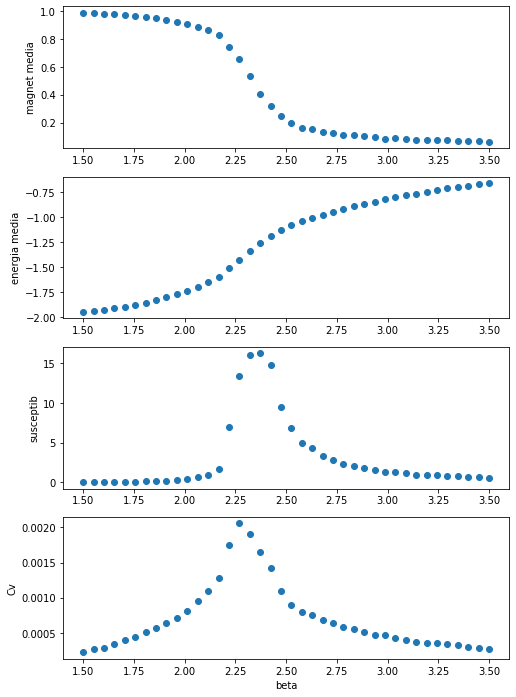

In [ ]:
plt.figure(figsize=(8,12))
plt.subplot(4,1,1)
plt.scatter(T, np.array(m_media))
plt.ylabel('magnet media')
plt.subplot(4,1,2)
plt.scatter(T, np.array(e_media))
plt.ylabel('energia media')
plt.subplot(4,1,3)
plt.scatter(T,np.array(m_var)*((L**2)/T))
plt.ylabel('susceptib')
plt.subplot(4,1,4)
plt.scatter(T,np.array(e_var)/(T**2))
plt.ylabel('Cv')
plt.xlabel('beta')
plt.show()

Para definir el **`npromedio`**, lo dividimos en 3 tramos porque quisimos tomar más puntos alrededor de temperaturas cerca de la crítica.

Definimos cuatro elementos: la magnetización media y la energía media, con sus respectivas varianzas, puesto que de las varianzas se obtiene la suceptibilidad magnética y la capacidad calorífica.

Para cada valor de $\beta$, iteramos la cantidad de **`nequilbrio`** para llegar a la matriz de equilibrio del ensamble canónico y luego aplicamos Metropolis la cantidad de veces de **`npromedio`** que queremos tomar. Esto último depende de si el valor de $T$ está cerca de la temperatura crítica o no. Como se vio en la celda de promedios, la magnetización promedio para un estado del canónico converge a un valor aproximadamente constante para **`npromedio`** largo por lo que, para cada temperatura, tomamos para graficar el último valor de magnetización media obtenido. Además, a medida que ibamos agregando elementos de magnetización, tomabamos la varianza de la magnetización que iba incrementando con Metropolis. De dicha varianza, tomamos el último valor para calcular la suceptibilidad. Todo esto se repite análogamente con la energía.

Para conocer la suceptibilidad utilizamos su relación con la varianza como $$χ=\frac{var(m) N}{T}$$
Donde $var(m)$ es la varianza de la magnetización, $N$ la cantidad de elemntos de la red y $T$ la temperatura.
Por otro lado, la capacidad calorífica la conocimos como $$c_v = \frac{var(e)}{T^2}$$
Donde $var(e)$ es la varianza de la energía y $c_v$ no depende de $N$ pues es una propiedad intensiva.


Las cuatro curvas de estudio tienen la forma esperada:
* La energía media es mínima a $T$ bajas (en el estado fundamental), mientras que la magnetización media es máxima. Inversamente, a $T$ bajas, la magnetización media tiende a cero y la energía se maximiza.
* Alrededor de la $T_c$ la suceptibilidad magnética y la capacidad calorífica alcanzan su máximo.

# Correlaciones

La **función de correlación** se define como $g(r)=\langle s_{ij}s_{ij+r}\rangle-\langle s_{ij}\rangle\langle s_{ij+r}\rangle$, y se sabe que tiene la forma $g(r)=ae^{-r/\xi}$. A $\xi$ se lo conoce como la **longitud de correlación**, y es una función de la temperatura que, en el límite termodinámico, diverge a la temperatura crítica. El objetivo de esta sección es ver eso.

Lo primero que hay que hacer es definir dos funciones. La primera, **`cor(S)`**, devuelve un vector $c$ de $L/2$ componentes, donde $L$ es el lado de la red, cuya componente $r$ es el promedio de $s_{ij}s_{ij+r}$ sobre toda la red, es decir,

$c(r)=\frac{1}{L^2}\sum_{i,j=1}^Ls_{ij}s_{ij+r}.$

La segunda función, **`metropolis2(S,prob)`**, implementa el algoritmo de Metropolis, igual que hacía la función **`metropolis(S,prob)`**, pero esta vez, en lugar de devolver el nuevo estado, el incremento de la magnetización y el incremento de energía, devuelve el nuevo estado, el incremento de la magnetización y el incremento del vector $c$. Para definir estas dos funciones deberán prestar mucha atención a las condiciones de contorno periódicas, y tener en cuenta que $c(0)=1$ independientemente del estado, así que el incremento de $c(0)$ siempre es $0$.

In [ ]:
@njit
def cor(S):
  m,n = np.shape(S) # me da las filas y columnas de la red
  c = np.zeros(int(m/2)) #me armo el vector que será la solución
  c[0]= m**2 #de esta manera el vector de correlación en la 1er coordenada es 1

  for r in range(1,int(m/2)): #que me recorra cada componente del vector c
    c_ = 0
    for i in range(0,m):
      j=0
      k = r
      while j < n:
        if (k)%n==0:
          k = 0
        y = S[i,j]*S[i,k] #cada termino de la suma para ir calculando c(r)
        c_ += y #aca voy sumando cada uno de los terminos
        k += 1
        j += 1

    c[r] = c_

  return c / (m**2) #divido por la longitud al cuadrado que como es cuadrada la red puede ser tanto m como n


@njit
def metropolis2(S,prob):
  m,n = np.shape(S)

  w = 0 #item para iterar
  S_final = np.copy(S) #Esta una copia de la matriz original (a w=0), que iremos cambiando con cada
                       #iteracion para que sea el output
  dm_ = 0
  de_ = 0 #defino el diferencial de energía acá también pues me va a decir si metrópolis hace o no el cambio
  dc_ = np.zeros((int(m/2)))
  while w < (m**2): #repito por los N sitios de la red
    w += 1 # para iterar en el while loop

    #elementos al azar de la red para la iteracion w
    i= np.random.randint(0,m)
    j= np.random.randint(0,n)

    #copio la matriz base para la w-esima iteracion y cambio el
    #spin del lugar (i,j)
    S_0 = np.copy(S_final)
    cambio = (-1)*S_0[i,j]
    S_0[i,j] = cambio

    #incremento de energia por particula, si cambio en S_0
    de= 0 #total de la serie
    for k in [-1,0,1]:
      for l in [-1,0,1]:
        a = i+k
        b = j+l

        if a%m ==0:
          a=0

        if b%n==0:
          b=0

        de += -S_0[a,b]*(S_0[a-1,b]+S_0[a,b-1])+ S_final[a,b]*(S_final[a-1,b]+S_final[a,b-1]) #diff de energia
                                                                                              #entre S con el cambio y
                                                                                              #la matriz de la w-esima iteracion

    # esta flag es para que ocurran cosas si se acepta el cambio
    flag = False

    if de <= 0:
      S_final = np.copy(S_0) #ACEPTAMOS EL CAMBIO
      flag = True
    elif de == (4):
      toss = np.random.rand()  #evento entre [0,1)
      if toss < prob[0]:
        S_final = np.copy(S_0) #ACEPTAMOS EL CAMBIO
        flag = True
      else:
        pass #No pasa nada, siga participando
    elif de == (8):
      toss = np.random.rand() #evento entre [0,1)
      if toss < prob[1]:
        S_final = np.copy(S_0) #ACEPTAMOS EL CAMBIO
        flag = True
      else:
        pass #No pasa nada, siga participando

    dm = 0
    if flag == True: #si acepta el cambio, hay un cambio de de y dm
      dm = np.sign(cambio)*(2/(m**2)) #cambio en m, saltos de 2/N, de acuerdo al
                                      #signo del cambio
      de_+=de/(m**2) #por particula

      dm_ += dm

      dc = np.zeros((int(m/2)))
      for r in range(1,int(m/2)):
        a = j+r
        b=j-r
        if a > m-1:
          a = a-m

        dc[r] = (2*cambio/(m**2))*(S_final[i,a]+S_final[i,b])

      dc_ =dc_+dc



  return S_final, dm_, dc_

Para el calculo de la correlación utilizamos 2 loops para iterar y sumar en $i$ y $j$, teniendo el cuidado de definir $k=j+r$ en los contornos adecuados. Para cada $r$ con el que se itera, se hace una suma distinta que ubicará la coordenada $r$ del vector de correlación de longitud $L/2$, en donde definimos que la primer coordenada cumpla que $c(0)=1$.

El algoritmo de **`metropolis2`** es análogo a la **`metropolis`** para el incremento de energía (utilizado para saber si se acepta o no el cambio en cada iteración) y la magnetización, donde dada la condición **`flag=True`**, se calcula el diferencial de magneización **`dm`** y el de correlación **`dc`**. Este útlimo diferencial surge de que para cada valor de $r$, dado un cambio en el spin $S_{ij}$, todos los terminos de la suma de $c(r)$ serán iguales salvo aquellos donde $S_{i'j'}=-S_{ij}$ (cambio de spin) y para $S_{i'j'+r} = S_{i'j'} = -S_{ij}$. Entonces, la diferencia de la longitud de correlación será $$c'(r) - c(r) = \frac{-2 S_{ij}}{N (S_{ij+r} + S_{ij-r})}$$

Luego, ese incremento $c'(r)-c(r)$ se agrega a cada incremento del vector correlación.

Ahora usamos las funciones que acabamos de definir para calcular la función de correlación a tres temperaturas distintas. Ajustamos los datos obtenidos con una función de la forma $a e^{-r/\xi}$, y de ahí obtenemos la longitud de correlación a esas tres temperaturas.

Longitud de correlacion:
T=1.5 => 0.41066453075030745
T=2.3 => 2.68572001111699
T=3 => 1.1705948666205204


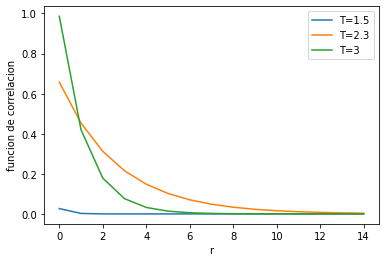

In [ ]:
L=30

nequilibrio=1000
npromedio=50000

l=int(L/2) #numero de componentes del vector c
m=np.zeros(npromedio) #magnetizacion en funcion del paso
c=np.zeros((l,npromedio)) #vector c en funcion del paso

erres=np.arange(l) #dominio de la funcion de correlacion
def fitcor(r,a,xi): #funcion con la que vamos a ajustar
  return a*np.exp(-r/xi)

S=np.ones((L,L),dtype=int)

print('Longitud de correlacion:')

for T in [1.5,2.3,3]:

  beta=1/T

  prob=np.array([np.exp(-4*beta),np.exp(-8*beta)])

  #Termalizamos con la funcion metropolis(S,prob), que es mas rapida
  for n in range(nequilibrio):
    S,dm,de=metropolis(S,prob)

  m[0]=np.mean(S)
  c[:,0]=cor(S)

  for n in range(1,npromedio):
    S,dm,dc=metropolis2(S,prob)
    m[n]=m[n-1]+dm
    c[:,n]=c[:,n-1]+dc

  mmedia=np.mean(abs(m))
  correlacion=np.mean(c,axis=1)-mmedia**2 #funcion de correlacion

  #Ajustamos:
  parametros,covarianza=curve_fit(fitcor,erres,correlacion)
  #(la funcion curve_fit devuelve el mejor valor de los parametros
  #y tambien la covarianza, que no vamos a usar)

  print('T={} => {}'.format(T,parametros[1]))

  plt.plot(erres,fitcor(erres,parametros[0],parametros[1]),label='T={}'.format(T))

plt.xlabel('r')
plt.ylabel('funcion de correlacion')
plt.legend()
plt.show()

Notar que para $r=0$, para temperatura alta respecto de la $T_c$ la correlacion tiende a $1$, pero a temperaturas bajas tiende a $0$.

A temperatura $0$ la varianza de $S[i,j]$ tiende a $0$. Pero a temperatura alta el valor medio es $0$, por ello la correlacion tiende a $1$.

Por último, hay que barrer un rango de temperaturas que incluya la crítica y obtener un gráfico de la longitud de correlación en función de la temperatura.

In [ ]:
L=30

nequilibrio=1000
npromedio=50000

l=int(L/2) #numero de componentes del vector c
m=np.zeros(npromedio) #magnetizacion en funcion del paso
c=np.zeros((l,npromedio)) #vector c en funcion del paso

erres=np.arange(l) #dominio de la funcion de correlacion
def fitcor(r,a,xi): #funcion con la que vamos a ajustar
  return a*np.exp(-r/xi)

Temp = np.linspace(1.5,3.5,40)

S=np.ones((L,L),dtype=int)

long_corr = []

for T in Temp:

  beta=1/T

  prob=np.array([np.exp(-4*beta),np.exp(-8*beta)])

  #Termalizamos con la funcion metropolis(S,prob), que es mas rapida
  for n in range(nequilibrio):
    S,dm,de=metropolis(S,prob)

  #el primero lo calculo de entrada a mano pues no queda otra...
  m[0]=np.mean(S)
  c[:,0]=cor(S)
  #...pero después uso el dm y el dc
  for n in range(1,npromedio):
    S,dm,dc=metropolis2(S,prob)
    m[n]=m[n-1]+dm
    c[:,n]=c[:,n-1]+dc

  mmedia=np.mean(abs(m)) #el abs sale de cuando la m no "sabe" si ser + o -
  correlacion=np.mean(c,axis=1)-mmedia**2 #funcion de correlacion

  #Ajustamos:
  parametros,covarianza=curve_fit(fitcor,erres,correlacion)
  #(la funcion curve_fit devuelve el mejor valor de los parametros
  #y tambien la covarianza, que no vamos a usar)

  long_corr.append(parametros[1])

Text(0, 0.5, 'Longitud de Correlacion')

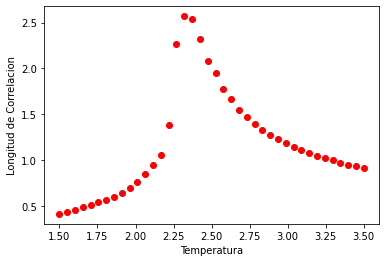

In [ ]:
plt.scatter(Temp, np.array(long_corr), color='r')
plt.xlabel('Temperatura')
plt.ylabel('Longitud de Correlacion')


Para poder graficar la longitud de correlación en función de la temperatura, se calculó el parámetro de ajuste $\xi$ de la función de correlación $g(r)=a e^{-r/\xi}$. Así, dado que cada curva de la función de correlación depende de la temperatura, se contruyó un vector de $\xi$ en función de las $T$ usadas para cada ajuste. Esto es lo que se ve en el grafico arriba, en donde se observa que la longitud de correlación diverge para la temperatura crítica $T_c$.

# Temperatura crítica

La teoría de **finite-size scaling** (Fisher y Barber, Physical Review Letters 28, 1972) muestra que, para una red de Ising bidimensional de lado $L$, el pico de la susceptibilidad ocurre a una temperatura $T_c(L)$ dada por

$$T_c(L)=T_c+\frac{a}{L},$$

donde $T_c$ es la temperatura crítica del sistema en el límite termodinámico y $a$ es una constante. Lo que deben hacer en esta sección es determinar $T_c(L)$ para $L=15,30,60,120$ con una precisión aproximada de $0.01$, graficar en función de $1/L$, ajustar los puntos a una recta y de ahí obtener una estimación para la temperatura crítica.

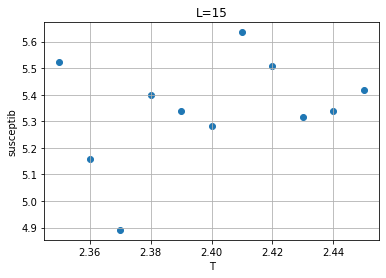

In [ ]:
# L = 15
T = np.arange(2.35,2.45,0.01)

neq = 5000
nprom = 40000

L=15
beta=1/T


m_var = []


S=np.ones((L,L),dtype=int)

for i in range(len(beta)):

    prob=np.array([np.exp(-4*beta[i]),np.exp(-8*beta[i])])

    for n in range(int(neq)):
        S,dm,de=metropolis(S,prob) #Termalizamos

    m=np.zeros(int(nprom))
    m[0]=np.mean(S)

    mmedia=[np.abs(m[0])]
    mvar= []
    for n in range(1,int(nprom)):
        S,dm,de=metropolis(S,prob)
        m[n]=m[n-1]+dm
        mvar.append(np.var(np.abs(m[0:n+1])))


    m_var.append(mvar[-1])

sucept = np.array(m_var)*((L**2)/T)
plt.scatter(T,sucept)
plt.title('L=15')
plt.xlabel('T')
plt.ylabel('susceptib')
plt.grid()

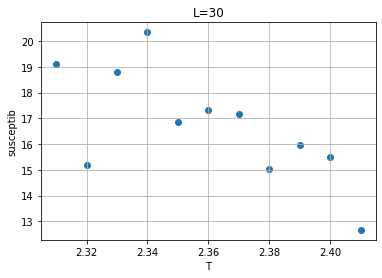

In [ ]:
#L = 30
T = np.arange(2.31,2.42,0.01)

neq = 5000
nprom = 20000

L=30
beta=1/T


m_var = []


S=np.ones((L,L),dtype=int)

for i in range(len(beta)):

    prob=np.array([np.exp(-4*beta[i]),np.exp(-8*beta[i])])

    for n in range(int(neq)):
        S,dm,de=metropolis(S,prob) #Termalizamos

    m=np.zeros(int(nprom))
    m[0]=np.mean(S)

    mmedia=[np.abs(m[0])]
    mvar= []
    for n in range(1,int(nprom)):
        S,dm,de=metropolis(S,prob)
        m[n]=m[n-1]+dm
        mvar.append(np.var(np.abs(m[0:n+1])))


    m_var.append(mvar[-1])

sucept = np.array(m_var)*((L**2)/T)
plt.scatter(T,sucept)
plt.title('L=30')
plt.xlabel('T')
plt.ylabel('susceptib')
plt.grid()

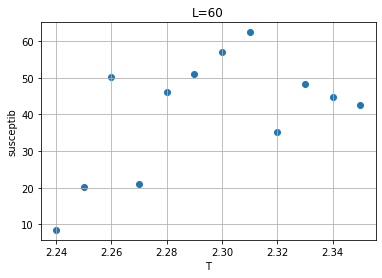

In [ ]:
#L = 60
T = np.arange(2.24,2.36,0.01)

neq = 5000
nprom = 20000

L=60
beta=1/T


m_var = []


S=np.ones((L,L),dtype=int)

for i in range(len(beta)):

    prob=np.array([np.exp(-4*beta[i]),np.exp(-8*beta[i])])

    for n in range(int(neq)):
        S,dm,de=metropolis(S,prob) #Termalizamos

    m=np.zeros(int(nprom))
    m[0]=np.mean(S)

    mmedia=[np.abs(m[0])]
    mvar= []
    for n in range(1,int(nprom)):
        S,dm,de=metropolis(S,prob)
        m[n]=m[n-1]+dm
        mvar.append(np.var(np.abs(m[0:n+1])))


    m_var.append(mvar[-1])

sucept = np.array(m_var)*((L**2)/T)
plt.scatter(T,sucept)
plt.title('L=60')
plt.xlabel('T')
plt.ylabel('susceptib')
plt.grid()

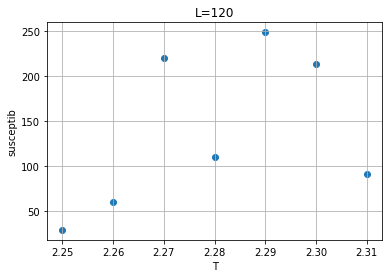

In [ ]:
#L = 120
T = np.arange(2.25,2.32,0.01)

neq = 5000
nprom = 10000

L=120
beta=1/T


m_var = []


S=np.ones((L,L),dtype=int)

for i in range(len(beta)):

    prob=np.array([np.exp(-4*beta[i]),np.exp(-8*beta[i])])

    for n in range(int(neq)):
        S,dm,de=metropolis(S,prob) #Termalizamos

    m=np.zeros(int(nprom))
    m[0]=np.mean(S)

    mmedia=[np.abs(m[0])]
    mvar= []
    for n in range(1,int(nprom)):
        S,dm,de=metropolis(S,prob)
        m[n]=m[n-1]+dm
        mvar.append(np.var(np.abs(m[0:n+1])))


    m_var.append(mvar[-1])

sucept = np.array(m_var)*((L**2)/T)
plt.scatter(T,sucept)
plt.title('L=120')
plt.xlabel('T')
plt.ylabel('susceptib')
plt.grid()

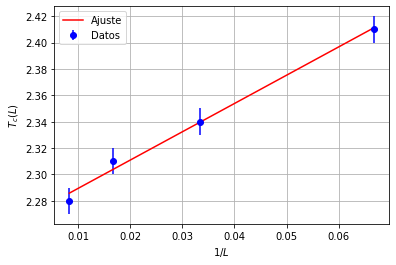

$T_{c}$:  2.27 +/- 0.01


In [ ]:
maxT = np.array([2.41, 2.34, 2.31, 2.28])

errmaxT = 0.01*np.ones(len(maxT))
L=np.array([15,30,60,120])
L_ =1/L
def func(x,A,B):
    return A*x+B

popt,pcov = curve_fit(func, L_,maxT, sigma=errmaxT, absolute_sigma=True)
plt.errorbar(L_, maxT, yerr=errmaxT, fmt='bo',label='Datos')
plt.plot(L_,func(L_,*popt), label='Ajuste', color='r')
plt.ylabel('$T_{c}(L)$')
plt.xlabel('$1/L$')
plt.grid(True)
plt.legend()
plt.show()
print('$T_{c}$: ', np.round(popt[1],2), '+/-', 0.01)

#**Explicación:** usen esta celda para explicar lo que hicieron

# **Discusión**

La temperatura crítica resulta consistente con el modelo de Onsager, pues hace una extrapolacion a partir de las temperaturas a las que ocurre el pico de suceptibilidad, apelando a que dicha tendencia lineal en la inversa del ancho de la matriz de spines se mantiene para el limite termodinamico. El ajuste entonces da un valor consistente con la solucion de onsager que es $\sim 2.2691$.

Respecto de la solucion de campo medio, la temperatura critica obtenida es mucho menor. Pues la aproximacion de campo medio asume que las fluctuaciones son pequeñas y que el sistema se comporta ordenadamente de acuerdo al spin promedio de la red, sobrestimando así la temperatura critica en $T_{c}=4$.